# CameraView and Rendering [todo]

* setting camera to frame
* grabbing img & depth
* converting to point clouds (and displaying)
* generating videos by saving pngs + ffmpeg
* realistic rendering using nvisii

## Grabbing images and depth from the view
The view is internally implemented using glfw and most basic opengl. It's simple to grab the rgb and depth buffers.

In [1]:
from robotic import ry
import numpy as np
import matplotlib.pyplot as plt
print(ry.__version__, ry.compiled())

0.0.22 compile time: Oct 11 2023 23:03:35


In [2]:
C = ry.Config()
C.addFile(ry.raiPath('scenarios/pandaSingle.g'))
C.view()

0

In [3]:
rgb = np.flip(C.view_getRgb(), axis=0)
depth = np.flip(C.view_getDepth(), axis=0)
print(rgb.shape, depth.shape)

(400, 400, 3) (400, 400)


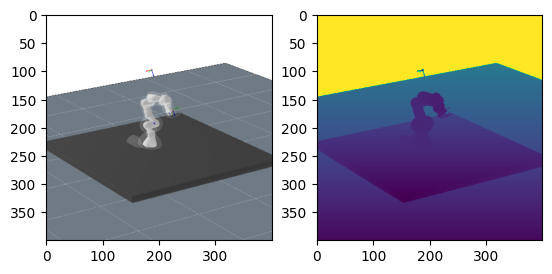

In [4]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(rgb)
fig.add_subplot(1,2,2)
plt.imshow(depth)
plt.show()

## Saving pngs for video generation

There might be many better ways to generate a video. But a simple one it to write many numered pngs and call ffmpeg on shell. For instance:

In [5]:
# first ensure a folder
import os
os.system('mkdir -p z.vid') 

0

In [6]:
q = C.getJointState()

for t in range(30):
    q = q + .02
    C.setJointState(q)
    C.view()
    C.view_savePng('z.vid/')

In [7]:
os.system('ffmpeg -f image2 -framerate 12 -i z.vid/%04d.png -c:v libx264 -r 25 -pix_fmt yuv420p vid.mp4')

ffmpeg version 4.4.4-0ubuntu1~20.04.sav1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version='0ubuntu1~20.04.sav1' --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-li

256

...which creates an mp4 with 12 images per second.

## Setting the camera

The camera post can be set to be at a particular frame. (Create a dedicated frame, if you want freedom to set the camera). Also camera intrinsics (focalLength, width, height) can be set with frame attributes:

In [11]:
f = C.getFrame('cameraTop') # cameraWrist is another pre-defined frame

In [12]:
C.view_setCamera(f)

In [13]:
f.setAttribute('focalLength', .2) # super wide angle
f.setAttribute('width', 200) # super wide angle
f.setAttribute('height', 200) # super wide angle
C.view_setCamera(f)

## Point Cloud

In [1]:
from robotic import ry

In [2]:
C = ry.Config()
C.addFile(ry.raiPath('scenarios/pandaSingle.g'))
C.view()

0

In [3]:
C.view_setCamera(C.getFrame('cameraWrist'))
depth = C.view_getDepth()
pcl = ry.depthImage2PointCloud(depth, C.view_fxycxy())

In [4]:
f = C.addFrame('pcl2', parent='cameraWrist')
f.setPointCloud(pcl, [1., .0, .0])

In [5]:
C.view()

86

## Background/headless & 

Camera images and depth are usually accessed via a simulation interface (BotOp). But we can compute images and depth also directly for a given configuration, without really creating a (physical) simulation. Here the basic approach: We can also add a frame, attached to the head, which has no shape associated to it, but create a view is associated with that frame
TODO: Add nvisii support/export!

In [ ]:
C.addFrame(name='camera', parent='head_tilt_link', args='Q:<d(-90 1 0 0) d(180 0 0 1)> focalLength:.3')
V = C.cameraView()

In [ ]:
Vimg = V.imageViewer()
Vseg = V.segmentationViewer()
Vpcl = V.pointCloudViewer()

In [2]:
V.addSensor('kinect', 'endeffKinect', 640, 480, 580./480., -1., [.1, 50.] )
#V.addSensor(name='camera', frameAttached='camera', width=600, height=400)
V.selectSensor('kinect')
[image,depth] = V.computeImageAndDepth()
seg = V.computeSegmentation()
pcl = V.computePointCloud(depth)
print('image shape:', image.shape)
print('depth shape:', depth.shape)
print('segmentation shape:', seg.shape)
print('pcl shape:', pcl.shape)

NameError: name 'V' is not defined

When we move the robot, that view moves with it:

In [ ]:
C.setJointState([0.5], ['head_pan_joint'])
C.setJointState([1.], ['head_tilt_joint'])
V.updateConfig(C)
[image,depth] = V.computeImageAndDepth()
pcl = V.computePointCloud(depth)

To close a view (or destroy a handle to a computational module), we reassign it to zero. We can also remove a frame from the configuration.

In [ ]:
Vimg = 0
Vseg = 0
Vpcl = 0
V = 0
C.delFrame('camera')

In [ ]:
C.view_close()